# Attack pipeline on Adult using a Decision Tree as explainer

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append("../../")
sys.path.append("../../lime/")
import mlem
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from sklearn.utils import shuffle
from sklearn import tree
from pathlib import Path

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV
from mlem.utilities import save_pickle_bz2, load_pickle_bz2

# DATA LOADING AND CONFIGURATION

In [3]:
from mlem.utilities import load_pickle_bz2

data for the attack

In [4]:
BLACK_BOX = load_pickle_bz2("../datasets/adult/BB_NO_CLUSTERING/BB_DATA/adult_rf_noclustering.bz2")
# x_train x_test y_train y_test x_test_clustered y_test_clustered
BLACK_BOX_DATA = np.load("../datasets/adult/BB_NO_CLUSTERING/BB_DATA/adult_rf_noclustering_data_nsamples_2.npz")
# on the version of diva we're using all the features are numeric
CATEGORICAL_FEATURES_MASK = ADULT_CATEGORICAL_FEATURES_MASK = [False, True, False, True, False, True, True, True, True, True, False, False, False, True]

In [5]:
train_distr = pd.DataFrame(BLACK_BOX_DATA['y_train']).value_counts(normalize=True)
test_distr = pd.DataFrame(BLACK_BOX_DATA['y_test']).value_counts(normalize=True)

In [6]:
print(f"train size = {len(BLACK_BOX_DATA['y_train'])} | test size = {len(BLACK_BOX_DATA['y_test'])} | total size = {len(BLACK_BOX_DATA['y_train']) + len(BLACK_BOX_DATA['y_test'])}")
print(f"train distribution:\n{train_distr}\n")
print(f"test distribution:\n{test_distr}")

train size = 16877 | test size = 7234 | total size = 24111
train distribution:
0    0.750963
1    0.249037
dtype: float64

test distribution:
0    0.750899
1    0.249101
dtype: float64


X and Y are the row to attack

In [7]:
INDEX = 0

In [8]:
X = BLACK_BOX_DATA['x_test_clustered'][INDEX]
Y = BLACK_BOX_DATA['y_test_clustered'][INDEX]

### building the explainer

Training the explainer on the training data of the black box

In [9]:
explainer_training_data = BLACK_BOX_DATA['x_train']
explainer = LimeTabularExplainer(training_data=explainer_training_data, categorical_features=[i for (i, el) in enumerate(CATEGORICAL_FEATURES_MASK) if el], random_state=123)

# Attack Pipeline on a single element

## 1) Creating the local explainer

at the end of this section the important variables will be:
* `local_model` : contains the local model (the ensemble classifier generated by LIME)
* `x_neigh` : contains the neighborhood generated by LIME
* `y_neigh`: contains the classification of `x_neigh` generated by the local_model

This code is contained in the `__get_local_data` function in the mlem code

In [10]:
explanations, lime_models, x_neigh = explainer.explain_instance(X, BLACK_BOX.predict_proba, labels=[0,1], sampling_method="gaussian", num_samples=5000, num_features=len(X))

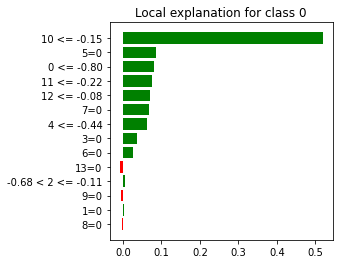

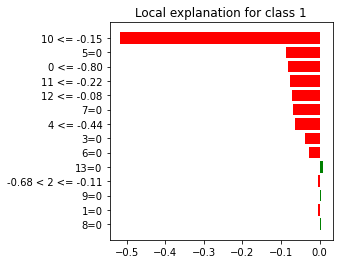

In [11]:
fig0 = explanations.as_pyplot_figure(label=0)
fig1 = explanations.as_pyplot_figure(label=1)

Difference between the points in the neighborhood and the original instance.

*The instances generated by LIME are not very close to the original instance, maybe we could generate neighborhoods in a loop and keep only the closest elements*

In [15]:
from mlem.utilities import norm_nocategorical
difference_from_X_cat = [np.linalg.norm(x_neigh[0]-x) for x in x_neigh]
difference_from_X_nocat = [norm_nocategorical(x_neigh[0]-x, CATEGORICAL_FEATURES_MASK) for x in x_neigh]
print(f"with cat:\tmax = {max(difference_from_X_cat[1:]):.2f} min = {min(difference_from_X_cat[1:]):.2f} avg = {np.average(difference_from_X_cat[1:]):.2f} std= {np.std(difference_from_X_cat[1:]):.2f}")
print(f"without cat:\tmax = {max(difference_from_X_nocat[1:]):.2f} min = {min(difference_from_X_nocat[1:]):.2f} avg = {np.average(difference_from_X_nocat[1:]):.2f} std= {np.std(difference_from_X_nocat[1:]):.2f}")

with cat:	max = 11.50 min = 0.55 avg = 2.75 std= 1.22
without cat:	max = 11.49 min = 0.42 avg = 2.69 std= 1.24


Creating the local model as ensamble of the models returned by lime

In [16]:
attack_dataset = pd.DataFrame(x_neigh)
attack_dataset['Target'] = BLACK_BOX.predict(attack_dataset.to_numpy())

In [17]:
attack_dataset.Target.value_counts()

0    4485
1     515
Name: Target, dtype: int64

In [18]:
def generate_balanced_dataset(x, num_samples, black_box, explainer, max_tries=15, shuffle=True, verbose=False):
    generated = pd.DataFrame(explainer.data_inverse(x, num_samples, 'gaussian')[1])
    generated['Target'] = black_box.predict(generated.to_numpy())
    min_class =-np.NINF
    final = pd.DataFrame()
    for t in range(max_tries):
        if verbose:
            print(f"try number {t}")
        
        if len(final) >= num_samples:
            
            return final.sample(frac=1) if shuffle else final
        
        generated = pd.DataFrame(explainer.data_inverse(x, num_samples, 'gaussian')[1])
        generated['Target'] = black_box.predict(generated.to_numpy())
        
        zeroes = generated[generated['Target'] == 0]
        ones   = generated[generated['Target'] == 1]
        
        if len(zeroes) == 0 or len(ones) == 0:
            continue
        
        if len(final) < num_samples:
            min_len = min(len(zeroes), len(ones))
            final = pd.concat([final, zeroes.head(min_len).copy(), ones.head(min_len).copy()])
    
        if verbose:
            p0, p1 = final.Target.value_counts(normalize=True)
            print(f"{len(final)=} {p0=} {p1=}")
        
        
    raise Exception("Could not generate balanced dataset")


In [19]:
#g = generate_balanced_dataset(X, 5000, BLACK_BOX, explainer, 20, True, True)

In [20]:
#g.to_csv("adult_lime_generated_around_0.csv", index=False)

In [21]:
generated_dataset = pd.read_csv("adult_lime_generated_around_0.csv")

In [22]:
ATTACK_DATASET = generated_dataset.copy()

In [23]:
ATTACK_DATASET

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Target
0,0.140810,0.218918,-1.151091,0.164328,1.788122,0.455011,0.124236,0.455728,0.263855,0.313955,-0.000003,0.0,-1.748542,0.254411,0
1,-0.522921,0.218918,-0.253538,0.421658,1.291273,0.455011,0.133907,0.014343,0.263855,0.313955,-0.000003,0.0,-0.648633,0.254411,0
2,-0.416459,0.218918,0.102679,0.749077,-1.481296,0.455011,0.448686,0.455728,0.263855,0.313955,-0.000003,0.0,1.071553,0.254411,1
3,-0.865284,0.218918,0.210266,0.164328,-0.048076,0.455011,0.061527,0.493599,0.263855,0.113783,-0.000003,0.0,-0.085408,0.125000,0
4,-0.991708,0.294630,-0.934414,0.200180,-1.291433,0.455011,0.116515,0.014343,0.129972,0.113783,2.179329,0.0,1.102858,0.348837,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,1.481100,0.218918,0.177651,0.421658,-0.048076,0.107312,0.202926,0.455728,0.263855,0.313955,2.302275,0.0,1.230300,0.254411,1
5956,0.141398,0.218918,0.440817,0.263198,-0.048076,0.455011,0.225590,0.455728,0.263855,0.313955,-0.000003,0.0,0.330406,0.254411,1
5957,0.740863,0.285829,-0.207593,0.056298,0.907419,0.048399,0.485342,0.493599,0.263855,0.313955,-0.000003,0.0,-1.050966,0.254411,0
5958,-0.443961,0.268960,-0.965144,0.200180,0.894671,0.455011,0.225590,0.106689,0.263855,0.313955,0.894925,0.0,-0.903759,0.254411,1


In [24]:
# Hyperparameters of the grid search
__HYPERPARAMETERS = {
    "criterion": ["gini", "entropy"],
}

def create_decision_tree(
        x_train,
        y_train,
        hyperparameters = __HYPERPARAMETERS,
        n_jobs=4,
        use_halving=True
):
    """Creates a random forest classifier via grid search.

    Args:
        x_train (ndarray): Training input examples.
        y_train (ndarray): Training target values.
        hyperparameters (Dict[str, List[Any]], optional): Dictionary of hyperparameters for the grid search. Defaults to the fixed ones.
        n_jobs: Number of jobs to run in parallel in the grid search. (default 4)
        use_halving (bool): If true use the HalvingGridSearch

    Returns:
        RandomForestClassifier: Random forest classifier.
    """

    dt = tree.DecisionTreeClassifier()

    if use_halving:
        clf = HalvingGridSearchCV(dt, hyperparameters, refit=True, n_jobs=n_jobs, verbose=0)
    else:
        clf = RandomizedSearchCV(dt, hyperparameters, refit=True, n_jobs=n_jobs, verbose=0)
    clf.fit(x_train, y_train)
    # print(f"GRID_SEARCH BEST PARAMS: {clf.best_params_=}")
    return clf.best_estimator_

In [25]:
X_train, X_test, y_train, y_test = train_test_split(generated_dataset.drop('Target', axis=1).to_numpy(), generated_dataset.Target.to_numpy(), test_size=0.33, random_state=42)

In [26]:
dt = create_decision_tree(X_train, y_train, use_halving=True) if not Path("decision_tree_adult_96.bz2").exists() else load_pickle_bz2("decision_tree_adult_96.bz2")

In [27]:
dt

DecisionTreeClassifier(criterion='entropy')

The decision tree has good performances

In [28]:
print(classification_report(y_test, dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       974
           1       0.97      0.97      0.97       993

    accuracy                           0.97      1967
   macro avg       0.97      0.97      0.97      1967
weighted avg       0.97      0.97      0.97      1967



Black Box

In [29]:
print(classification_report(y_test, BLACK_BOX.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       974
           1       1.00      1.00      1.00       993

    accuracy                           1.00      1967
   macro avg       1.00      1.00      1.00      1967
weighted avg       1.00      1.00      1.00      1967



In [30]:
pd.DataFrame(y_test).value_counts()

1    993
0    974
dtype: int64

In [31]:
if not Path("decision_tree_adult_96.bz2").exists():
    save_pickle_bz2("decision_tree_adult_96.bz2", dt)
    np.savez("decision_tree_adult_96.data.npz", X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

# Attacking the decision tree

In [32]:
from mlem.shadow_models import ShadowModelsManager

Reloading the tree and its data

In [33]:
local_tree = load_pickle_bz2("decision_tree_adult_96.bz2")
loaded     = np.load("decision_tree_adult_96.data.npz", allow_pickle=True)

In [34]:
X_train = loaded['X_train']
X_test  = loaded['X_test']
y_train = loaded['y_train']
y_test  = loaded['y_test']
full_generated_dataset = pd.read_csv("adult_lime_generated_around_0.csv")

Using the lime generated dataset as x_attack and the labels computed by the dt as y_attack

In [35]:
x_attack = full_generated_dataset.drop('Target', axis=1)
y_attack = local_tree.predict(x_attack.to_numpy())

Comparing the local_tree predictions to the "real" label

In [36]:
(y_attack == full_generated_dataset.Target).value_counts(normalize=True)

True     0.989765
False    0.010235
Name: Target, dtype: float64

### with Adaboost

using adaboost for the ShadowModels

In [37]:
from mlem.utilities import create_adaboost

path="DT/shadow_adab_adult_dt"

shadow_models = ShadowModelsManager(
        n_models=4,
        results_path=f"{path}/shadow",
        test_size=0.5,
        random_state=123,
        model_creator_fn=create_adaboost,
        categorical_mask=CATEGORICAL_FEATURES_MASK
    )

Fitting 4 shadow models on the data

In [38]:
shadow_models.fit(x_attack, y_attack)

In [39]:
attack_dataset = shadow_models.get_attack_dataset()
attack_dataset

,0,1,label,inout
0,0.477977,0.522023,1,in
1,0.577727,0.422273,0,in
2,0.260569,0.739431,1,in
3,0.469193,0.530807,1,in
4,0.302552,0.697448,1,in
...,...,...,...,...
2975,0.526214,0.473786,0,out
2976,0.393850,0.606150,1,out
2977,0.483609,0.516391,1,out
2978,0.485508,0.514492,1,out


The mean and std are close to 0.5 and 0

In [40]:
attack_dataset[attack_dataset.label == 0][[0,1]].describe()

,0,1
count,11948.000000,11948.000000
mean,0.538986,0.461014
std,0.026344,0.026344
min,0.306083,0.342384
25%,0.520563,0.447343
50%,0.535124,0.464876
75%,0.552657,0.479437
max,0.657616,0.693917


In [41]:
attack_dataset[attack_dataset.label == 1][[0,1]].describe()

,0,1
count,11916.000000,11916.000000
mean,0.428226,0.571774
std,0.057591,0.057591
min,0.236076,0.457911
25%,0.403088,0.520225
50%,0.436135,0.563865
75%,0.479775,0.596912
max,0.542089,0.763924


In [42]:
attack_dataset_ins = attack_dataset[attack_dataset.inout == 'in']#.drop('inout', axis=1)
attack_dataset_outs = attack_dataset[attack_dataset.inout == 'out']#.drop('inout', axis=1)

In [43]:
int_df = pd.merge(attack_dataset_ins, attack_dataset_outs, how ='inner', on =[0, 1])

**These probability distributions appear both with the label in and out in the attack dataset**

In [44]:
int_df

,0,1,label_x,inout_x,label_y,inout_y
0,0.471677,0.528323,1,in,1,out
1,0.499757,0.500243,1,in,1,out
2,0.499757,0.500243,1,in,1,out
3,0.310976,0.689024,1,in,1,out
4,0.568934,0.431066,0,in,0,out
...,...,...,...,...,...,...
291,0.494748,0.505252,1,in,1,out
292,0.422505,0.577495,1,in,1,out
293,0.382770,0.617230,1,in,1,out
294,0.434924,0.565076,1,in,1,out


Creating the attack model for each label using Adaboost

In [45]:
from mlem.attack_models import AttackModelsManager, AttackStrategy
attack_models = AttackModelsManager(
        results_path=f"DT/attack_adab_adult_dt", model_creator_fn=create_adaboost, attack_strategy=AttackStrategy.ONE_PER_LABEL
)

In [46]:
attack_models.fit(attack_dataset)

[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling


Loading the attack models just created

In [47]:
atk_0 = load_pickle_bz2("DT/attack_adab_adult_dt/0/model.pkl.bz2")
atk_1 = load_pickle_bz2("DT/attack_adab_adult_dt/1/model.pkl.bz2")

### Attack on the whole datasets of the BB

In [48]:
def attack_bb_dataset(atk_0, atk_1, bb_data=BLACK_BOX_DATA):
    
    # extracting train and test set of the BB
    BB_TRAIN = pd.DataFrame(bb_data['x_train'])
    BB_TRAIN['Target'] = bb_data['y_train']

    BB_TEST = pd.DataFrame(bb_data['x_test'])
    BB_TEST['Target'] = bb_data['y_test']
    
    # for each set separate the elements belonging to class 0 from the ones of class 1
    BB_TEST_0 = BB_TEST[BB_TEST.Target == 0]
    BB_TEST_1 = BB_TEST[BB_TEST.Target == 1]

    BB_TRAIN_0 = BB_TRAIN[BB_TRAIN.Target == 0]
    BB_TRAIN_1 = BB_TRAIN[BB_TRAIN.Target == 1]
    
    # use the black box to compute the probabilities
    BB_TEST_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_0.drop('Target', axis=1).to_numpy()))
    BB_TEST_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_1.drop('Target', axis=1).to_numpy()))
    BB_TRAIN_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_0.drop('Target', axis=1).to_numpy()))
    BB_TRAIN_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_1.drop('Target', axis=1).to_numpy()))
    
    # use the attack models
    BB_TEST_0['ATK'] = atk_0.predict(BB_TEST_0.to_numpy())
    BB_TEST_1['ATK'] = atk_1.predict(BB_TEST_1.to_numpy())
    
    BB_TRAIN_0['ATK'] = atk_0.predict(BB_TRAIN_0.to_numpy())
    BB_TRAIN_1['ATK'] = atk_1.predict(BB_TRAIN_1.to_numpy())
    
    # assign the true label to each element so that it can be easily compared to the one from the attack model
    BB_TEST_0['Y'] = 'out'
    BB_TEST_1['Y'] = 'out'
    BB_TRAIN_0['Y'] = 'in'
    BB_TRAIN_1['Y'] = 'in'
    
    # concatenate everything
    train_test = pd.concat([BB_TEST_0, BB_TEST_1,BB_TRAIN_0, BB_TRAIN_1])
    return train_test

In [49]:
def attack_dataset(atk_0, atk_1, train, test):
    
    # extracting train and test set of the BB
    BB_TRAIN = train

    BB_TEST = test
    
    # for each set separate the elements belonging to class 0 from the ones of class 1
    BB_TEST_0 = BB_TEST[BB_TEST.Target == 0]
    BB_TEST_1 = BB_TEST[BB_TEST.Target == 1]

    BB_TRAIN_0 = BB_TRAIN[BB_TRAIN.Target == 0]
    BB_TRAIN_1 = BB_TRAIN[BB_TRAIN.Target == 1]
    
    # use the black box to compute the probabilities
    BB_TEST_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_0.drop('Target', axis=1).to_numpy()))
    BB_TEST_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_1.drop('Target', axis=1).to_numpy()))
    BB_TRAIN_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_0.drop('Target', axis=1).to_numpy()))
    BB_TRAIN_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_1.drop('Target', axis=1).to_numpy()))
    
    # use the attack models
    BB_TEST_0['ATK'] = atk_0.predict(BB_TEST_0.to_numpy())
    BB_TEST_1['ATK'] = atk_1.predict(BB_TEST_1.to_numpy())
    
    BB_TRAIN_0['ATK'] = atk_0.predict(BB_TRAIN_0.to_numpy())
    BB_TRAIN_1['ATK'] = atk_1.predict(BB_TRAIN_1.to_numpy())
    
    # assign the true label to each element so that it can be easily compared to the one from the attack model
    BB_TEST_0['Y'] = 'out'
    BB_TEST_1['Y'] = 'out'
    BB_TRAIN_0['Y'] = 'in'
    BB_TRAIN_1['Y'] = 'in'
    
    # concatenate everything
    train_test = pd.concat([BB_TEST_0, BB_TEST_1,BB_TRAIN_0, BB_TRAIN_1])
    return train_test

In [50]:
train_test = attack_bb_dataset(atk_0, atk_1)

In [51]:
print(classification_report(train_test.Y, train_test.ATK))

              precision    recall  f1-score   support

          in       0.70      0.83      0.76     16877
         out       0.32      0.18      0.23      7234

    accuracy                           0.64     24111
   macro avg       0.51      0.51      0.50     24111
weighted avg       0.59      0.64      0.60     24111



In [52]:
train_test[train_test.Y == 'out'].ATK.value_counts()

in     5935
out    1299
Name: ATK, dtype: int64

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fe947b1c190>


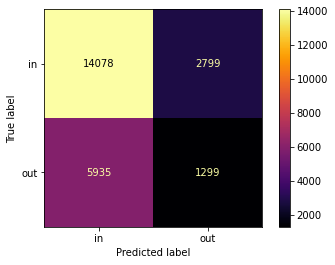

In [53]:
ConfusionMatrixDisplay.from_predictions(train_test.Y, train_test.ATK, cmap='inferno')

Let's see the behavior on the points closest to the instance used to create the neighborhood

In [54]:
import scipy.spatial.distance as distance

The distance column contains the distance from the point used to generate the neighborhood

In [55]:
BB_DATA_TR = pd.DataFrame(BLACK_BOX_DATA['x_train'])
BB_DATA_TR['Target'] = BLACK_BOX_DATA['y_train']
BB_DATA_TR['Distance'] = distance.cdist(BLACK_BOX_DATA['x_train'], [X], metric="euclidean")

BB_DATA_TE = pd.DataFrame(BLACK_BOX_DATA['x_test'])
BB_DATA_TE['Target'] = BLACK_BOX_DATA['y_test']
BB_DATA_TE['Distance'] = distance.cdist(BLACK_BOX_DATA['x_test'], [X], metric="euclidean")

In [56]:
BB_DATA_TR.Distance.describe()

count    16877.000000
mean         2.501770
std          1.457291
min          0.085012
25%          1.649780
50%          2.275654
75%          3.035977
max         14.413855
Name: Distance, dtype: float64

In [57]:
BB_DATA_TE.Distance.describe()

count    7234.000000
mean        2.496813
std         1.418222
min         0.000000
25%         1.648631
50%         2.278651
75%         3.053983
max        14.435124
Name: Distance, dtype: float64

In [58]:
print(f"{len(BB_DATA_TR[BB_DATA_TR.Distance < 2.5])=}")
print(f"{len(BB_DATA_TE[BB_DATA_TE.Distance < 3])=}")

len(BB_DATA_TR[BB_DATA_TR.Distance < 2.5])=9824
len(BB_DATA_TE[BB_DATA_TE.Distance < 3])=5349


In [59]:
BB_DATA_TR[BB_DATA_TR.Distance < 2.5].Target.value_counts(normalize=True)

0    0.846397
1    0.153603
Name: Target, dtype: float64

In [60]:
BB_DATA_TE[BB_DATA_TE.Distance < 3].Target.value_counts(normalize=True)

0    0.810058
1    0.189942
Name: Target, dtype: float64

Creating the dataset with the closest points

In [61]:
BB_TRAIN = BB_DATA_TR[BB_DATA_TR.Distance < 2.5].drop('Distance', axis=1)
BB_TEST = BB_DATA_TE[BB_DATA_TE.Distance < 3].drop('Distance', axis=1)

In [62]:
train_test_close = attack_dataset(atk_0, atk_1, BB_TRAIN, BB_TEST)

In [63]:
print(classification_report(train_test_close.Y, train_test_close.ATK))

              precision    recall  f1-score   support

          in       0.66      0.86      0.74      9824
         out       0.40      0.17      0.24      5349

    accuracy                           0.62     15173
   macro avg       0.53      0.51      0.49     15173
weighted avg       0.56      0.62      0.56     15173



In [64]:
train_test[train_test.Y == 'out'].ATK.value_counts()

in     5935
out    1299
Name: ATK, dtype: int64

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fe946a07910>


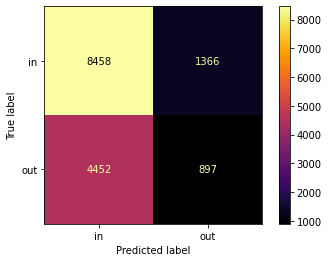

In [65]:
ConfusionMatrixDisplay.from_predictions(train_test_close.Y, train_test_close.ATK, cmap='inferno')

Creating dataset with points closer that 1

In [66]:
print(f"{len(BB_DATA_TR[BB_DATA_TR.Distance < 1])=}")
print(f"{len(BB_DATA_TE[BB_DATA_TE.Distance < 1])=}")

len(BB_DATA_TR[BB_DATA_TR.Distance < 1])=1352
len(BB_DATA_TE[BB_DATA_TE.Distance < 1])=597


In [67]:
BB_TRAIN = BB_DATA_TR[BB_DATA_TR.Distance < 1].drop('Distance', axis=1)
BB_TEST = BB_DATA_TE[BB_DATA_TE.Distance < 1].drop('Distance', axis=1)

In [68]:
train_test_closer_1 = attack_dataset(atk_0, atk_1, BB_TRAIN, BB_TEST)

In [69]:
print(classification_report(train_test_closer_1.Y, train_test_closer_1.ATK))

              precision    recall  f1-score   support

          in       0.69      0.98      0.81      1352
         out       0.33      0.03      0.05       597

    accuracy                           0.69      1949
   macro avg       0.51      0.50      0.43      1949
weighted avg       0.58      0.69      0.58      1949



In [70]:
train_test_closer_1[train_test_closer_1.Y == 'out'].ATK.value_counts()

in     582
out     15
Name: ATK, dtype: int64

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fe9469b13a0>


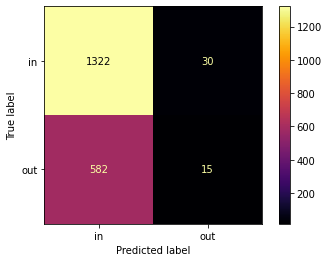

In [71]:
ConfusionMatrixDisplay.from_predictions(train_test_closer_1.Y, train_test_closer_1.ATK, cmap='inferno')

### with a nn instead of Adaboost

In [72]:
import logging
logging.disable('DEBUG')

In [73]:
from mlem.utilities import create_nn_model_keras

path="DT/shadow_nn_adult_dt"

shadow_models = ShadowModelsManager(
        n_models=4,
        results_path=f"{path}/shadow",
        test_size=0.5,
        random_state=123,
        model_creator_fn=create_nn_model_keras,
        categorical_mask=CATEGORICAL_FEATURES_MASK
    )

Fitting 4 shadow models on the data

In [74]:
shadow_models.fit(x_attack, y_attack)

2022-10-04 13:11:27.411492: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-10-04 13:11:27.411545: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: pop-os
2022-10-04 13:11:27.411551: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: pop-os
2022-10-04 13:11:27.411727: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2022-10-04 13:11:27.411751: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.85.2
2022-10-04 13:11:27.412378: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:

Epoch 1/20
84/84 [==============================] - 0s 2ms/step - loss: 0.5970 - accuracy: 0.6197 - val_loss: 0.4975 - val_accuracy: 0.8127
Epoch 2/20
84/84 [==============================] - 0s 702us/step - loss: 0.3833 - accuracy: 0.8478 - val_loss: 0.3195 - val_accuracy: 0.8629
Epoch 3/20
84/84 [==============================] - 0s 717us/step - loss: 0.2460 - accuracy: 0.9096 - val_loss: 0.2332 - val_accuracy: 0.9097
Epoch 4/20
84/84 [==============================] - 0s 711us/step - loss: 0.1744 - accuracy: 0.9423 - val_loss: 0.1766 - val_accuracy: 0.9298
Epoch 5/20
84/84 [==============================] - 0s 720us/step - loss: 0.1383 - accuracy: 0.9501 - val_loss: 0.1476 - val_accuracy: 0.9431
Epoch 6/20
84/84 [==============================] - 0s 710us/step - loss: 0.1153 - accuracy: 0.9579 - val_loss: 0.1356 - val_accuracy: 0.9498
Epoch 7/20
84/84 [==============================] - 0s 718us/step - loss: 0.1031 - accuracy: 0.9613 - val_loss: 0.1417 - val_accuracy: 0.9465
Epoch 8/

2022-10-04 13:11:29.561188: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
INFO:tensorflow:Assets written to: ram://9e845ae6-6462-4aac-81c1-4e05c0a9595f/assets


Epoch 1/20
84/84 [==============================] - 0s 2ms/step - loss: 0.6014 - accuracy: 0.7756 - val_loss: 0.4942 - val_accuracy: 0.8294
Epoch 2/20
84/84 [==============================] - 0s 728us/step - loss: 0.3838 - accuracy: 0.8679 - val_loss: 0.3160 - val_accuracy: 0.8629
Epoch 3/20
84/84 [==============================] - 0s 733us/step - loss: 0.2434 - accuracy: 0.9066 - val_loss: 0.2293 - val_accuracy: 0.9097
Epoch 4/20
84/84 [==============================] - 0s 714us/step - loss: 0.1753 - accuracy: 0.9341 - val_loss: 0.1753 - val_accuracy: 0.9431
Epoch 5/20
84/84 [==============================] - 0s 734us/step - loss: 0.1417 - accuracy: 0.9475 - val_loss: 0.1496 - val_accuracy: 0.9465
Epoch 6/20
84/84 [==============================] - 0s 707us/step - loss: 0.1141 - accuracy: 0.9643 - val_loss: 0.1338 - val_accuracy: 0.9431
Epoch 7/20
84/84 [==============================] - 0s 696us/step - loss: 0.1023 - accuracy: 0.9658 - val_loss: 0.1304 - val_accuracy: 0.9465
Epoch 8/

INFO:tensorflow:Assets written to: ram://5630c00a-645f-492d-a419-2d0c75e7fb4f/assets


Epoch 1/20
84/84 [==============================] - 0s 2ms/step - loss: 0.5502 - accuracy: 0.7581 - val_loss: 0.4368 - val_accuracy: 0.7926
Epoch 2/20
84/84 [==============================] - 0s 699us/step - loss: 0.3239 - accuracy: 0.8656 - val_loss: 0.3169 - val_accuracy: 0.8528
Epoch 3/20
84/84 [==============================] - 0s 712us/step - loss: 0.2281 - accuracy: 0.9066 - val_loss: 0.2323 - val_accuracy: 0.8863
Epoch 4/20
84/84 [==============================] - 0s 725us/step - loss: 0.1715 - accuracy: 0.9349 - val_loss: 0.1813 - val_accuracy: 0.9365
Epoch 5/20
84/84 [==============================] - 0s 733us/step - loss: 0.1384 - accuracy: 0.9479 - val_loss: 0.1565 - val_accuracy: 0.9365
Epoch 6/20
84/84 [==============================] - 0s 704us/step - loss: 0.1226 - accuracy: 0.9565 - val_loss: 0.1436 - val_accuracy: 0.9498
Epoch 7/20
84/84 [==============================] - 0s 711us/step - loss: 0.1121 - accuracy: 0.9579 - val_loss: 0.1274 - val_accuracy: 0.9599
Epoch 8/

INFO:tensorflow:Assets written to: ram://67f71f78-e7ec-4271-bf0a-8507c0209468/assets


Epoch 1/20
84/84 [==============================] - 0s 2ms/step - loss: 0.6047 - accuracy: 0.6677 - val_loss: 0.4203 - val_accuracy: 0.8495
Epoch 2/20
84/84 [==============================] - 0s 705us/step - loss: 0.3367 - accuracy: 0.8701 - val_loss: 0.2705 - val_accuracy: 0.8963
Epoch 3/20
84/84 [==============================] - 0s 717us/step - loss: 0.2344 - accuracy: 0.9070 - val_loss: 0.2022 - val_accuracy: 0.9164
Epoch 4/20
84/84 [==============================] - 0s 751us/step - loss: 0.1822 - accuracy: 0.9241 - val_loss: 0.1676 - val_accuracy: 0.9365
Epoch 5/20
84/84 [==============================] - 0s 758us/step - loss: 0.1491 - accuracy: 0.9427 - val_loss: 0.1325 - val_accuracy: 0.9532
Epoch 6/20
84/84 [==============================] - 0s 744us/step - loss: 0.1259 - accuracy: 0.9524 - val_loss: 0.1253 - val_accuracy: 0.9498
Epoch 7/20
84/84 [==============================] - 0s 749us/step - loss: 0.1145 - accuracy: 0.9565 - val_loss: 0.1068 - val_accuracy: 0.9565
Epoch 8/

INFO:tensorflow:Assets written to: ram://274d79b2-caf4-4a40-b93c-745dabbc76e9/assets


In [75]:
attack_dataset_nn = shadow_models.get_attack_dataset()
attack_dataset_nn

,0,1,label,inout
0,0.000780,0.999220,1,in
1,0.000000,1.000000,1,in
2,0.999518,0.000482,0,in
3,0.000000,1.000000,1,in
4,0.767535,0.232465,1,in
...,...,...,...,...
2975,0.000001,0.999999,1,out
2976,0.996194,0.003806,0,out
2977,0.999926,0.000074,0,out
2978,0.000000,1.000000,1,out


In [76]:
attack_dataset_nn[attack_dataset_nn.label == 0][[0,1]].describe()

,0,1
count,11948.000000,1.194800e+04
mean,0.956883,4.311667e-02
std,0.146051,1.460507e-01
min,0.000013,9.649531e-10
25%,0.995372,3.148127e-05
50%,0.999571,4.292876e-04
75%,0.999969,4.627958e-03
max,1.000000,9.999868e-01


In [77]:
attack_dataset_nn[attack_dataset_nn.label == 1][[0,1]].describe()

,0,1
count,11916.000000,11916.000000
mean,0.055569,0.944431
std,0.153494,0.153494
min,0.000000,0.000579
25%,0.000000,0.979782
50%,0.000025,0.999975
75%,0.020218,1.000000
max,0.999421,1.000000


In [78]:
attack_dataset_nn[attack_dataset_nn.inout == 'in'][[0,1]].describe()

,0,1
count,11944.000000,1.194400e+04
mean,0.506566,4.934343e-01
std,0.475997,4.759973e-01
min,0.000000,1.671891e-09
25%,0.000021,4.266724e-04
50%,0.516689,4.833106e-01
75%,0.999573,9.999789e-01
max,1.000000,1.000000e+00


In [79]:
attack_dataset_nn[attack_dataset_nn.inout == 'out'][[0,1]].describe()

,0,1
count,11920.000000,1.192000e+04
mean,0.507095,4.929046e-01
std,0.473846,4.738459e-01
min,0.000000,9.649531e-10
25%,0.000028,4.273281e-04
50%,0.542552,4.574482e-01
75%,0.999573,9.999718e-01
max,1.000000,1.000000e+00


In [80]:
attack_dataset_ins_nn = attack_dataset_nn[attack_dataset_nn.inout == 'in']#.drop('inout', axis=1)
attack_dataset_outs_nn = attack_dataset_nn[attack_dataset_nn.inout == 'out']#.drop('inout', axis=1)

Creating the attack models for each label **using Adaboost**

In [81]:
from mlem.attack_models import AttackModelsManager, AttackStrategy
from mlem.utilities import create_adaboost

attack_models = AttackModelsManager(
        results_path=f"DT/attack_nn_adult_dt", model_creator_fn=create_adaboost, attack_strategy=AttackStrategy.ONE_PER_LABEL
)

In [82]:
attack_dataset_nn

,0,1,label,inout
0,0.000780,0.999220,1,in
1,0.000000,1.000000,1,in
2,0.999518,0.000482,0,in
3,0.000000,1.000000,1,in
4,0.767535,0.232465,1,in
...,...,...,...,...
2975,0.000001,0.999999,1,out
2976,0.996194,0.003806,0,out
2977,0.999926,0.000074,0,out
2978,0.000000,1.000000,1,out


In [83]:
attack_models.fit(attack_dataset_nn)

[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling


In [84]:
atk_0 = load_pickle_bz2("DT/attack_nn_adult_dt/0/model.pkl.bz2")
atk_1 = load_pickle_bz2("DT/attack_nn_adult_dt/1/model.pkl.bz2")

### Attack on the whole datasets of the BB

In [85]:
train_test = attack_bb_dataset(atk_0, atk_1)

In [86]:
print(classification_report(train_test.Y, train_test.ATK))

              precision    recall  f1-score   support

          in       0.71      0.46      0.56     16877
         out       0.31      0.55      0.39      7234

    accuracy                           0.49     24111
   macro avg       0.51      0.51      0.48     24111
weighted avg       0.59      0.49      0.51     24111



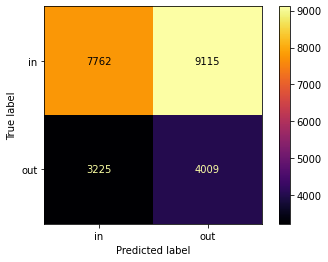

In [87]:
ConfusionMatrixDisplay.from_predictions(train_test.Y, train_test.ATK, cmap='inferno')

In [88]:
train_test[train_test.Y == 'out'].ATK.value_counts()

out    4009
in     3225
Name: ATK, dtype: int64

Let's see on the points closest to the instance used to create the neighborhood

In [89]:
import scipy.spatial.distance as distance

In [90]:
BB_DATA_TR = pd.DataFrame(BLACK_BOX_DATA['x_train'])
BB_DATA_TR['Target'] = BLACK_BOX_DATA['y_train']
BB_DATA_TR['Distance'] = distance.cdist(BLACK_BOX_DATA['x_train'], [X], metric="euclidean")

BB_DATA_TE = pd.DataFrame(BLACK_BOX_DATA['x_test'])
BB_DATA_TE['Target'] = BLACK_BOX_DATA['y_test']
BB_DATA_TE['Distance'] = distance.cdist(BLACK_BOX_DATA['x_test'], [X], metric="euclidean")

In [91]:
BB_DATA_TR.Distance.describe()

count    16877.000000
mean         2.501770
std          1.457291
min          0.085012
25%          1.649780
50%          2.275654
75%          3.035977
max         14.413855
Name: Distance, dtype: float64

In [92]:
BB_DATA_TE.Distance.describe()

count    7234.000000
mean        2.496813
std         1.418222
min         0.000000
25%         1.648631
50%         2.278651
75%         3.053983
max        14.435124
Name: Distance, dtype: float64

In [93]:
BB_DATA_TR[BB_DATA_TR.Distance < 2.5].Target.value_counts(normalize=True)

0    0.846397
1    0.153603
Name: Target, dtype: float64

In [94]:
BB_DATA_TE[BB_DATA_TE.Distance < 3].Target.value_counts(normalize=True)

0    0.810058
1    0.189942
Name: Target, dtype: float64

Creating the dataset with the closest points

In [95]:
BB_TRAIN = BB_DATA_TR[BB_DATA_TR.Distance < 2.5].drop('Distance', axis=1)
BB_TEST = BB_DATA_TE[BB_DATA_TE.Distance < 3].drop('Distance', axis=1)

In [96]:
train_test_close = attack_dataset(atk_0, atk_1, BB_TRAIN, BB_TEST)

In [97]:
print(classification_report(train_test_close.Y, train_test_close.ATK))

              precision    recall  f1-score   support

          in       0.65      0.45      0.54      9824
         out       0.36      0.56      0.44      5349

    accuracy                           0.49     15173
   macro avg       0.51      0.51      0.49     15173
weighted avg       0.55      0.49      0.50     15173



In [98]:
train_test_close[train_test_close.Y == 'out'].ATK.value_counts()

out    2998
in     2351
Name: ATK, dtype: int64

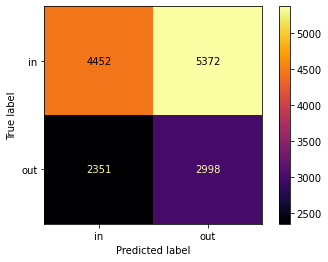

In [99]:
ConfusionMatrixDisplay.from_predictions(train_test_close.Y, train_test_close.ATK, cmap='inferno')

Creating dataset with points closer that 1

In [100]:
print(f"{len(BB_DATA_TR[BB_DATA_TR.Distance < 1])=}")
print(f"{len(BB_DATA_TE[BB_DATA_TE.Distance < 1])=}")

len(BB_DATA_TR[BB_DATA_TR.Distance < 1])=1352
len(BB_DATA_TE[BB_DATA_TE.Distance < 1])=597


In [101]:
BB_TRAIN = BB_DATA_TR[BB_DATA_TR.Distance < 1].drop('Distance', axis=1)
BB_TEST = BB_DATA_TE[BB_DATA_TE.Distance < 1].drop('Distance', axis=1)

In [102]:
train_test_closer_1 = attack_dataset(atk_0, atk_1, BB_TRAIN, BB_TEST)

In [103]:
print(classification_report(train_test.Y, train_test.ATK))

              precision    recall  f1-score   support

          in       0.71      0.46      0.56     16877
         out       0.31      0.55      0.39      7234

    accuracy                           0.49     24111
   macro avg       0.51      0.51      0.48     24111
weighted avg       0.59      0.49      0.51     24111



In [104]:
train_test[train_test.Y == 'out'].ATK.value_counts()

out    4009
in     3225
Name: ATK, dtype: int64

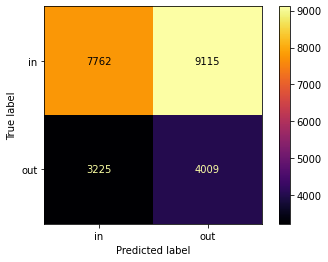

In [105]:
ConfusionMatrixDisplay.from_predictions(train_test.Y, train_test.ATK, cmap='inferno')

# Attack on the whole dataset

In [106]:
x_atk_dataset = BLACK_BOX_DATA['x_test_clustered']
y_atk_dataset = BLACK_BOX_DATA['y_test_clustered']

In [107]:
print(f"{len(x_atk_dataset)=} {len(y_atk_dataset)=}")

len(x_atk_dataset)=48 len(y_atk_dataset)=48


### Run the attack for each row

In [108]:
OUTPUT_ATTACK_FULL_FOLDER = Path("ADULT_ATTACK_DT_FULL")
OUTPUT_ATTACK_FULL_FOLDER.mkdir(exist_ok=True)

Generate the data for the attack using LIME and the black box and save it

In [109]:
for i, (x_atk, y_atk) in enumerate(zip(x_atk_dataset, y_atk_dataset)):
    print(f"Generating data for row {i}")
    path_ = OUTPUT_ATTACK_FULL_FOLDER / f"{i}"
    path_.mkdir(exist_ok=True)
    
    balanced_dataset = generate_balanced_dataset(x_atk, 5000, BLACK_BOX, explainer, 20, True, verbose=False)
    balanced_dataset.to_csv(path_ / "lime_generated.csv", index=False)

Generating data for row 0
Generating data for row 1
Generating data for row 2
Generating data for row 3
Generating data for row 4
Generating data for row 5
Generating data for row 6
Generating data for row 7
Generating data for row 8
Generating data for row 9
Generating data for row 10
Generating data for row 11
Generating data for row 12
Generating data for row 13
Generating data for row 14
Generating data for row 15
Generating data for row 16
Generating data for row 17
Generating data for row 18
Generating data for row 19
Generating data for row 20
Generating data for row 21
Generating data for row 22
Generating data for row 23
Generating data for row 24
Generating data for row 25
Generating data for row 26
Generating data for row 27
Generating data for row 28
Generating data for row 29
Generating data for row 30
Generating data for row 31
Generating data for row 32
Generating data for row 33
Generating data for row 34
Generating data for row 35
Generating data for row 36
Generating 

Splitting the generated data in train/test and building the decision trees

In [110]:
for i in range(len(x_atk_dataset)):
    p = OUTPUT_ATTACK_FULL_FOLDER / f"{i}" / "lime_generated.csv"
    gen_dataset = pd.read_csv(p)
    # splitting into train and test
    X_train, X_test, y_train, y_test = train_test_split(gen_dataset.drop('Target', axis=1).to_numpy(), gen_dataset.Target.to_numpy(), test_size=0.33, random_state=42)
    # creating the decision tree
    dt_path = OUTPUT_ATTACK_FULL_FOLDER / f"{i}" / "dt_adult.bz2"
    dt = create_decision_tree(X_train, y_train, use_halving=True) if not dt_path.exists() else load_pickle_bz2(dt_path)
    print(f"DT #{i}")
    print(classification_report(y_test, dt.predict(X_test)))
    if not dt_path.exists():
        save_pickle_bz2(dt_path, dt)
        np.savez(str(OUTPUT_ATTACK_FULL_FOLDER / f"{i}" / "dt_adult_data.npz"), X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

DT #0
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       982
           1       0.96      0.96      0.96       985

    accuracy                           0.96      1967
   macro avg       0.96      0.96      0.96      1967
weighted avg       0.96      0.96      0.96      1967

DT #1
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       867
           1       0.94      0.94      0.94       800

    accuracy                           0.94      1667
   macro avg       0.94      0.94      0.94      1667
weighted avg       0.94      0.94      0.94      1667

DT #2
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       861
           1       0.97      0.96      0.97       823

    accuracy                           0.97      1684
   macro avg       0.97      0.97      0.97      1684
weighted avg       0.97      0.97      0.97      1684

D

## Attacking every decision tree

In [111]:
from mlem.shadow_models import ShadowModelsManager
from mlem.utilities import create_adaboost
from mlem.attack_models import AttackModelsManager, AttackStrategy

Reloading the tree and its data

In [112]:
for i in range(len(x_atk_dataset)):
    
    p = OUTPUT_ATTACK_FULL_FOLDER / f"{i}"
    local_tree = load_pickle_bz2(p / "dt_adult.bz2")
    loaded = np.load(str(p / "dt_adult_data.npz"), allow_pickle=True)
    # 
    X_train = loaded['X_train']
    X_test  = loaded['X_test']
    y_train = loaded['y_train']
    y_test  = loaded['y_test']
    # Using the lime generated dataset as x_attack and the labels computed by the dt as y_attack
    full_generated_dataset = pd.read_csv(p / "lime_generated.csv")
    x_attack = full_generated_dataset.drop('Target', axis=1)
    y_attack = local_tree.predict(x_attack.to_numpy())
    # creating the shadow models
    path_shadow= str(p / "shadow_adab_adult_dt")

    shadow_models = ShadowModelsManager(
        n_models=4,
        results_path=f"{path_shadow}/shadow",
        test_size=0.5,
        random_state=123,
        model_creator_fn=create_adaboost,
        categorical_mask=CATEGORICAL_FEATURES_MASK
    )
    # fitting the shadow models
    shadow_models.fit(x_attack, y_attack)
    # extracting the attack dataset
    attack_dataset = shadow_models.get_attack_dataset()
    # Creating the attack model for each label using Adaboost
    path_attack = str(p / "attack_adab_adult_dt")
    attack_models = AttackModelsManager(
            results_path=path_attack, model_creator_fn=create_adaboost, attack_strategy=AttackStrategy.ONE_PER_LABEL
    )
    attack_models.fit(attack_dataset)

[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specifi

Loading the attack models just created

In [113]:
attacks_0 = []
attacks_1 = []
for i in range(len(x_atk_dataset)):
    p = OUTPUT_ATTACK_FULL_FOLDER / f"{i}" / "attack_adab_adult_dt"
    atk_0 = load_pickle_bz2( p/ "0" / "model.pkl.bz2")
    atk_1 = load_pickle_bz2( p/ "1" / "model.pkl.bz2")
    attacks_0.append(atk_0)
    attacks_1.append(atk_1)

Creating the ensemble classifiers

In [114]:
from mlem.ensemble import HardVotingClassifier, SoftVotingClassifier, KMostSureVotingClassifier

In [115]:
ens_0 = HardVotingClassifier(attacks_0)
ens_1 = HardVotingClassifier(attacks_1)

Attacking the black box dataset

In [116]:
train_test = attack_bb_dataset(ens_0, ens_1)

In [117]:
t2 = train_test[train_test.ATK != 'even']

In [118]:
print(classification_report(t2.Y, t2.ATK))

              precision    recall  f1-score   support

          in       0.70      0.84      0.76     16521
         out       0.32      0.18      0.23      7096

    accuracy                           0.64     23617
   macro avg       0.51      0.51      0.50     23617
weighted avg       0.59      0.64      0.60     23617



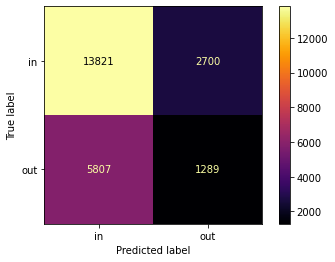

In [119]:
ConfusionMatrixDisplay.from_predictions(t2.Y, t2.ATK, cmap='inferno')

In [120]:
ens_0s = SoftVotingClassifier(attacks_0)
ens_1s = SoftVotingClassifier(attacks_1)

In [121]:
train_test = attack_bb_dataset(ens_0s, ens_1s)

t2 = train_test[train_test.ATK != 'even']

print(classification_report(t2.Y, t2.ATK))

              precision    recall  f1-score   support

          in       0.70      0.86      0.77     16877
         out       0.32      0.16      0.21      7234

    accuracy                           0.65     24111
   macro avg       0.51      0.51      0.49     24111
weighted avg       0.59      0.65      0.61     24111



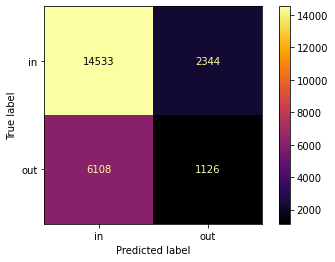

In [122]:
ConfusionMatrixDisplay.from_predictions(t2.Y, t2.ATK, cmap='inferno')

In [123]:
ens_0k = KMostSureVotingClassifier(attacks_0)
ens_1k = KMostSureVotingClassifier(attacks_1)

In [124]:
train_test = attack_bb_dataset(ens_0k, ens_1k)

t2 = train_test[train_test.ATK != 'even']

print(classification_report(t2.Y, t2.ATK))

              precision    recall  f1-score   support

          in       0.70      0.10      0.17     16877
         out       0.30      0.90      0.45      7234

    accuracy                           0.34     24111
   macro avg       0.50      0.50      0.31     24111
weighted avg       0.58      0.34      0.25     24111



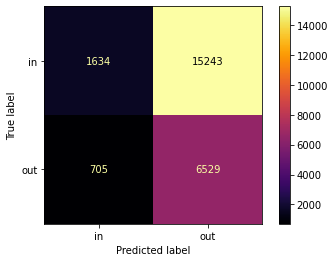

In [125]:
ConfusionMatrixDisplay.from_predictions(t2.Y, t2.ATK, cmap='inferno')

With K=3 we have better results than K=5

In [126]:
ens_0k3 = KMostSureVotingClassifier(attacks_0, k=3)
ens_1k3 = KMostSureVotingClassifier(attacks_1, k=3)

In [127]:
train_test = attack_bb_dataset(ens_0k3, ens_1k3)

t2 = train_test[train_test.ATK != 'even']

print(classification_report(t2.Y, t2.ATK))

              precision    recall  f1-score   support

          in       0.70      0.73      0.72     16877
         out       0.31      0.29      0.30      7234

    accuracy                           0.60     24111
   macro avg       0.51      0.51      0.51     24111
weighted avg       0.59      0.60      0.59     24111



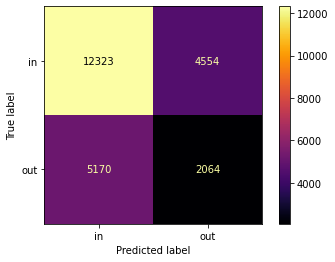

In [128]:
ConfusionMatrixDisplay.from_predictions(t2.Y, t2.ATK, cmap='inferno')

K=1 is like k=3

In [129]:
ens_0k1 = KMostSureVotingClassifier(attacks_0, k=1)
ens_1k1 = KMostSureVotingClassifier(attacks_1, k=1)

In [130]:
train_test = attack_bb_dataset(ens_0k1, ens_1k1)

t2 = train_test[train_test.ATK != 'even']

print(classification_report(t2.Y, t2.ATK))

              precision    recall  f1-score   support

          in       0.70      0.73      0.71     16877
         out       0.31      0.29      0.30      7234

    accuracy                           0.59     24111
   macro avg       0.51      0.51      0.51     24111
weighted avg       0.59      0.59      0.59     24111



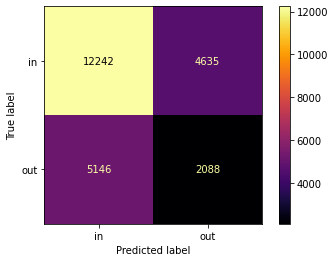

In [131]:
ConfusionMatrixDisplay.from_predictions(t2.Y, t2.ATK, cmap='inferno')

In [132]:
ens_0k7 = KMostSureVotingClassifier(attacks_0, k=7)
ens_1k7 = KMostSureVotingClassifier(attacks_1, k=7)

In [133]:
train_test = attack_bb_dataset(ens_0k7, ens_1k7)

t2 = train_test[train_test.ATK != 'even']

print(classification_report(t2.Y, t2.ATK))

              precision    recall  f1-score   support

          in       0.70      0.12      0.21     16877
         out       0.30      0.88      0.45      7234

    accuracy                           0.35     24111
   macro avg       0.50      0.50      0.33     24111
weighted avg       0.58      0.35      0.28     24111



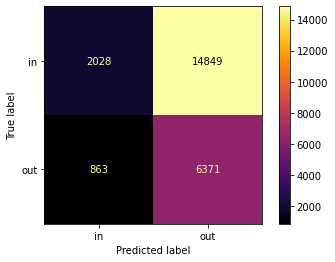

In [134]:
ConfusionMatrixDisplay.from_predictions(t2.Y, t2.ATK, cmap='inferno')